## Explanation of the input data:

The data in <b>train_data.csv </b>  is related to cancer diagnoses of different types. Each case includes information on the properties <i> (radius, texture and perimeter) of the three most characteristic cell nuclei </i>. 
Moreover, the **age of the person, the date of the diagnose and treatment start, as well as the cancer type** is available. The same information is also present in the file test_data.csv, only the cancer type is missing.

## Explanation of the Task:

- Perform an exploratory data analysis
- What are abnormalities in the data?
    * there are many cases with treatment date before diagnosis, specially at older ages. Maybe they have reoccurance of the cancer after treatment.
- Are there any interesting, perhaps unexpected correlations to be found?
- Create a model for predicting the cancer_type
- Select an appropriate model and keep its complexity reasonable (number of used features, etc.)

I would like you to send me a submission.csv for the cases in test_data.csv at least **one hour before the interview** that includes the *prediction of the cancer_type of your model*. The cases should be in the same order as in the test_data.csv and should only contain the label of the predicted cancer_type. See the sample_submission.csv for format clarification.
 

## Table of Content
- [1 - Packages](#1)
- [2 - Loading the training data](#2)
- [3 -  Preprocessing the training data and generate new features](#3)
- [4 - start of the training part](#4)
    - [4.1 - Train, validation splits](#4-1)
    - [4.2 - Get Feeling of associations between features and if there are any features with clear separation between the two classes.](#4-2)
- [5 - Preprocessing the Actual_test of submission file the same way](#5)
- [6 - Model selection and fitting the best model:](#6)
    - [6.1 - feature loadings of the first two PCs:](#6-1)

<a name='1'></a>
## 1 - Packages

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#!pip install seaborn
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score

In [2]:
os.chdir('/Users/skharabian/sciebo/CV_2020/Interviews/BohringerIngelheim/Technical_interview/data/task_1_cancer/')


<a name='2'></a>
## 2 -  Loading the training data

In [3]:
df = pd.read_csv('train_data.csv', index_col=None)

<a name='3'></a>
## 3 -  Preprocessing the training data and generate new features

In [4]:
df['cancer_type'] = df.cancer_type.astype('category')
df =df.replace({'texture_2': {'xx': np.nan}})
df['texture_2'] = pd.to_numeric(df['texture_2'])
df['treatment_date'] = pd.to_datetime(df['treatment_date'])
df['diagnose_date'] = pd.to_datetime(df['diagnose_date'])
df['treatment_diagnosis'] = (df['treatment_date'] -df['diagnose_date']).dt.days

In [5]:
# replacing Nans with mean of the other subjects
column_means = df.mean()
df = df.fillna(column_means)
df.describe(include='all')

/Users/skharabian/miniconda3/envs/Conreg36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
/Users/skharabian/miniconda3/envs/Conreg36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.
/Users/skharabian/miniconda3/envs/Conreg36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from s

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type,treatment_diagnosis
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398,398,398.0,398.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371,352,2.0,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-04-27 00:00:00,2005-04-01 00:00:00,1.0,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,250.0,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-19 00:00:00,2002-01-09 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-11-26 00:00:00,2007-11-15 00:00:00,NaN,NaN
mean,21.303711,18.957554,92.128890,14.123575,30.417222,94.086379,14.134922,19.459098,127.222422,39.876884,NaN,NaN,NaN,-198.015075
std,49.987646,6.243499,25.159787,3.508995,15.027855,22.231836,3.748146,5.684066,49.097558,13.427196,NaN,NaN,NaN,1055.455741
min,6.401956,-17.243202,45.612505,5.752395,2.395868,43.444930,7.079847,-0.966998,44.918942,18.000000,NaN,NaN,NaN,-2694.000000
25%,11.693885,14.581364,74.975361,11.841313,19.898062,82.575868,11.573592,15.711594,84.123724,28.000000,NaN,NaN,NaN,-1032.000000


In [6]:
# Start with creating matrices for training. 
X = df.drop(['cancer_type', 'treatment_date', 'diagnose_date'], axis=1)
y = df.cancer_type.values

<a name='4'></a>
## 4 - start of the training part: 

<a name='4-1'></a>
### 4.1 - Train, validation splits:

In [7]:
# set a validation set aside: 
from sklearn.model_selection import train_test_split
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train = X_train_df.values
X_test = X_test_df.values



In [11]:
print(y_train.value_counts())

0     99
1    167
dtype: int64


In [12]:
y_test.value_counts()

0    49
1    83
dtype: int64

<a name='4-2'></a>
### 4.2 - Get Feeling of associations between features and if there are any features with clear separation between the two classes. 

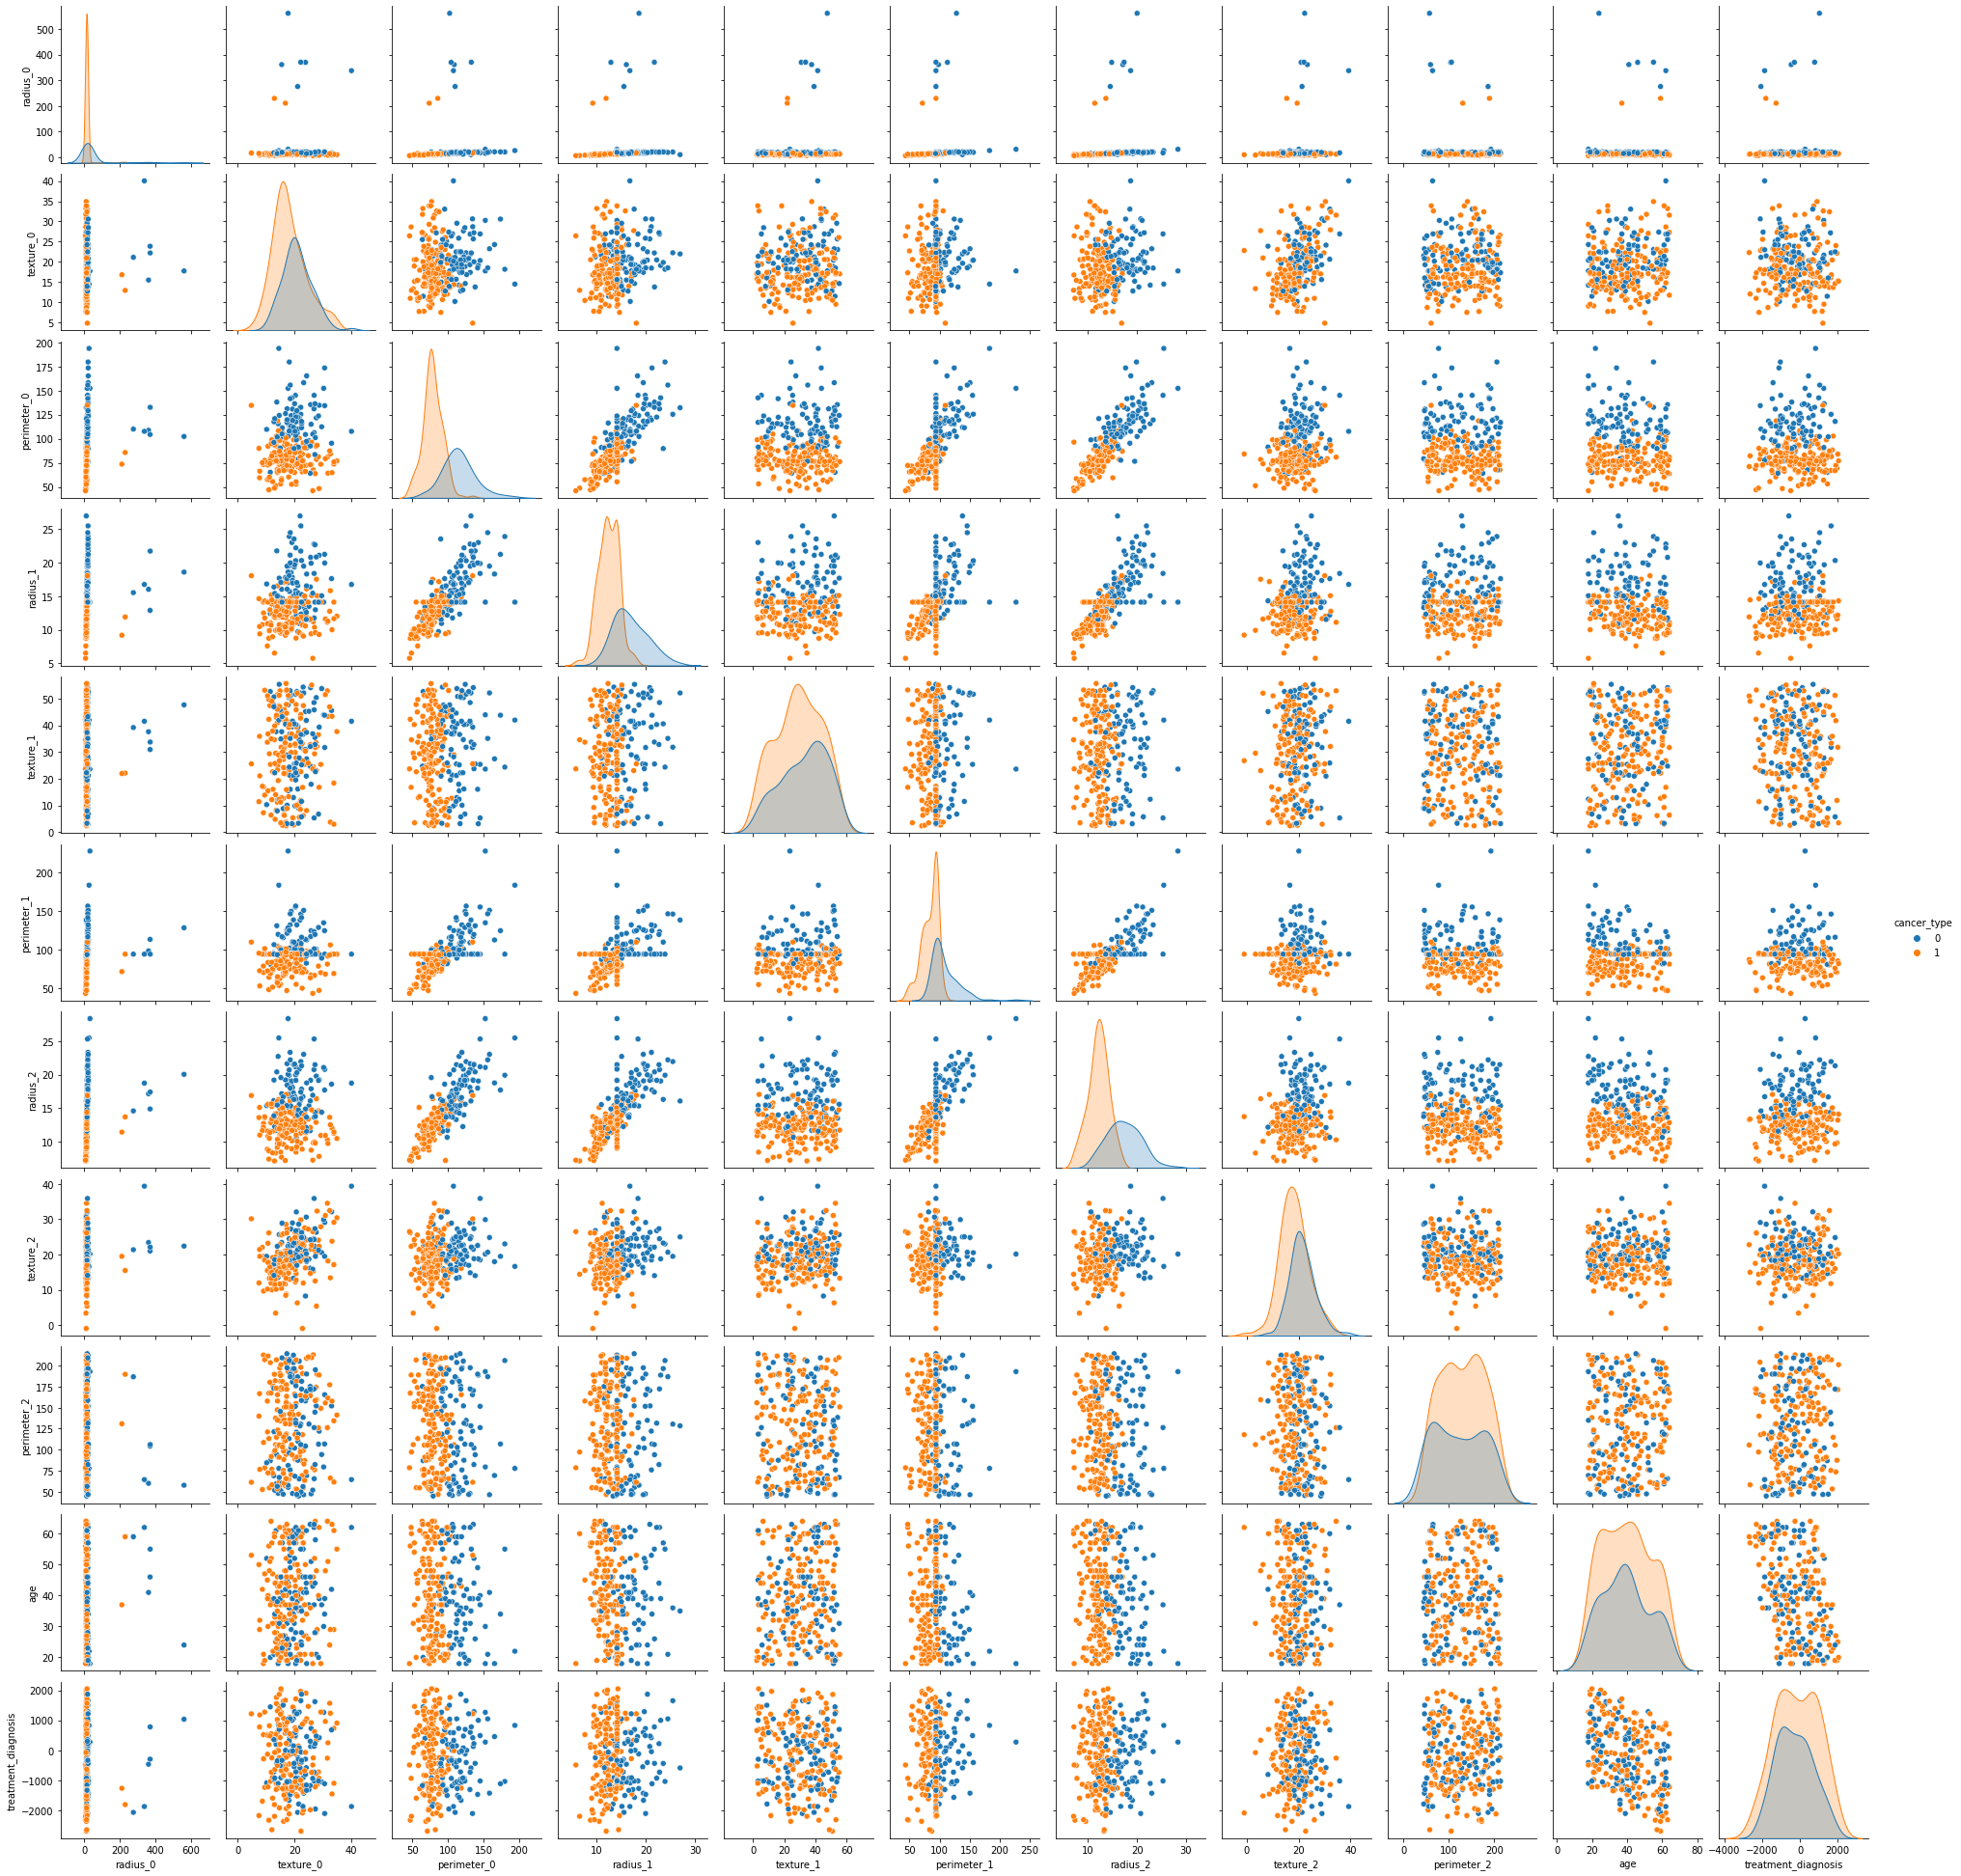

In [13]:
# Now only work on the training data:

# pairwise correlations

X_train_df.reset_index(inplace=True)
df_train = X_train_df.copy()
df_train.drop(['index'], axis =1, inplace=True)
df_train['cancer_type'] = y_train

# save the mean of each parameter for later use to impute the actual test missing values:
mean_impute = df_train.mean()
sb.pairplot(df_train, hue = 'cancer_type')

<a name='5'></a>
## 5 - Preprocessing the Actual_test of submission file the same way

In [14]:
# for actual test:
Test_df = pd.read_csv('test_data.csv')
Test_df

# perform the same preprocessing:
Test_df =Test_df.replace({'texture_2': {'xx': np.nan}})
Test_df['texture_2'] = pd.to_numeric(Test_df['texture_2'])
Test_df['treatment_date'] = pd.to_datetime(Test_df['treatment_date'])
Test_df['diagnose_date'] = pd.to_datetime(Test_df['diagnose_date'])
Test_df['treatment_diagnosis'] = (Test_df['treatment_date'] -Test_df['diagnose_date']).dt.days
Test_df = Test_df.fillna(mean_impute)
Test_df.describe(include='all')

# Start with creating matrices for training. 
Test_X = Test_df.drop(['treatment_date', 'diagnose_date'], axis=1)
Test_X_val = Test_X.values 
#ZTest_X_val = standard_obj.transform(X_test)

/Users/skharabian/miniconda3/envs/Conreg36/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  if sys.path[0] == '':
/Users/skharabian/miniconda3/envs/Conreg36/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  if sys.path[0] == '':


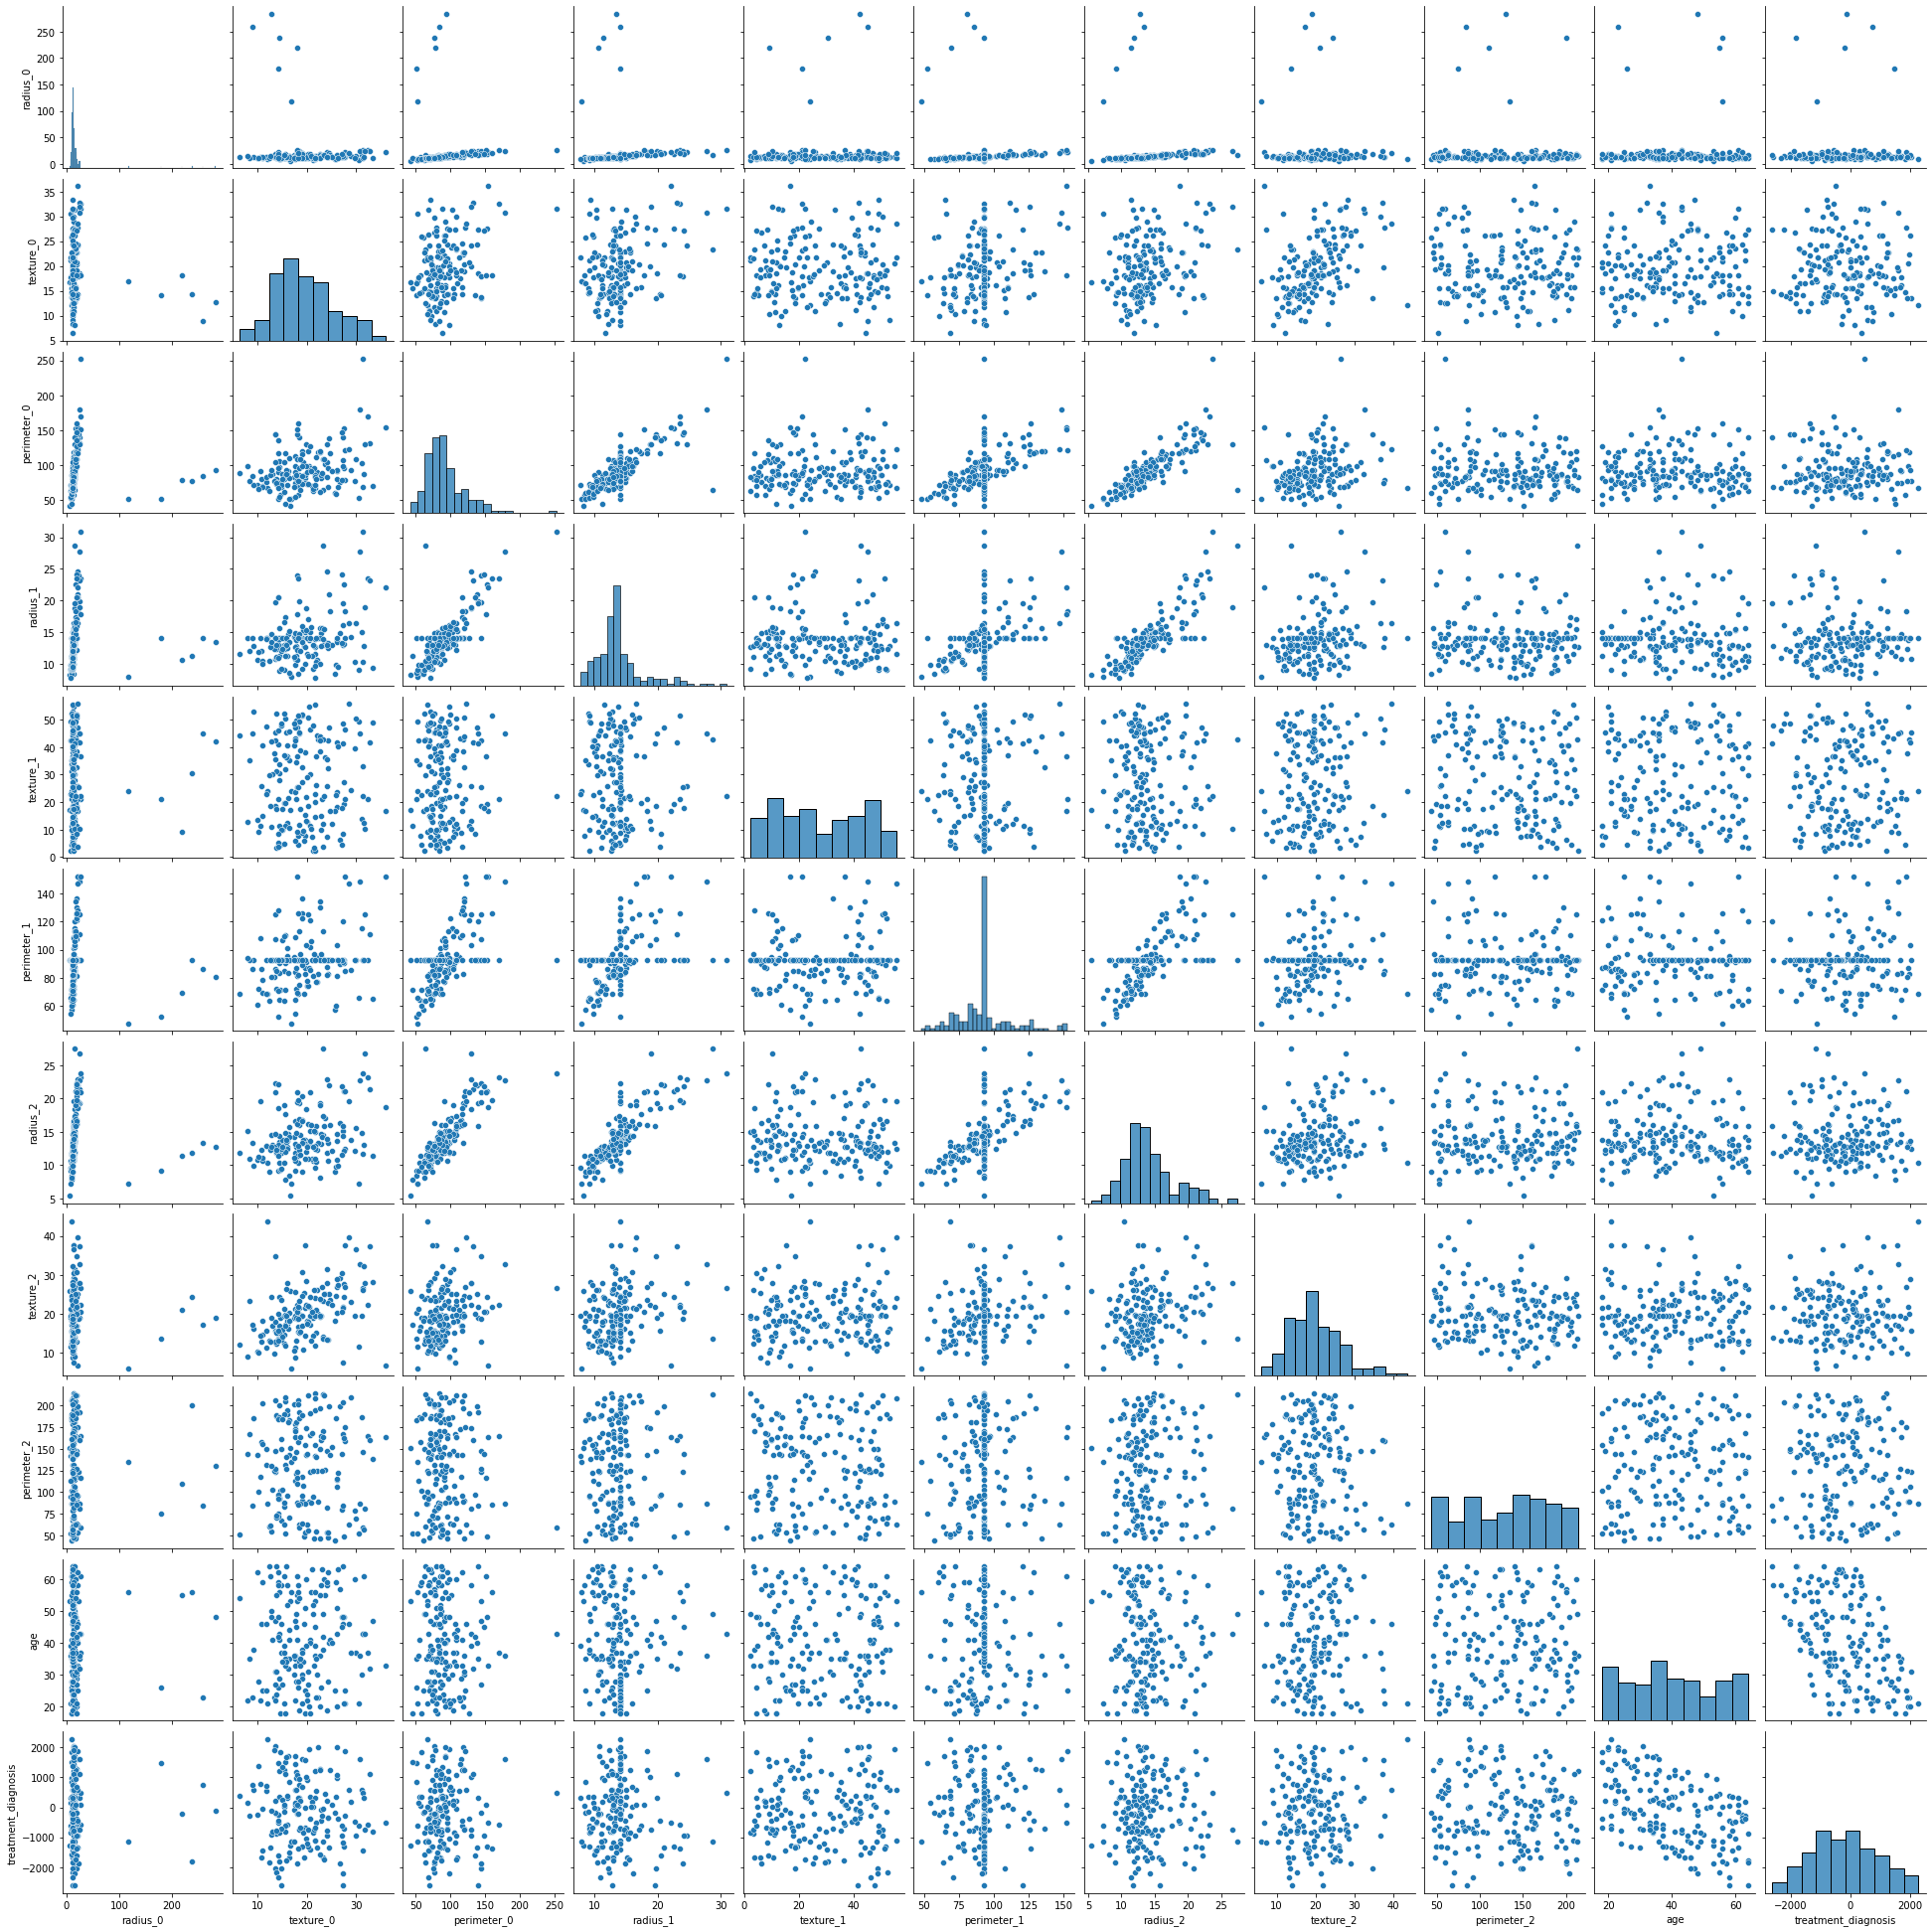

In [15]:
sb.pairplot(Test_X)

# Next steps: 
## We need to:
- Standardize the data
- Most likely reduce the dimension
- perform classification

---> To choose the number of components of features and best classifier, I used here Gridsearchcv

<a name='6'></a>
## 6 - Model selection and fitting the best model:

In [16]:
### Testing mltiple pipelines: 

# Construct some pipelines
pipe_lr_pca = Pipeline([('scl', StandardScaler()),
                        ('reduce_dim', PCA()),
                        ('clf', LogisticRegression(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
                        ('reduce_dim', PCA()),
                        ('clf', RandomForestClassifier(random_state=42))])



pipe_svm_pca = Pipeline([('scl', StandardScaler()),
                         ('reduce_dim', PCA()),
                         ('clf', svm.SVC(random_state=42))])



# Set grid search params
N_FEATURES_OPTIONS = [2, 3, 4, 5, 6, 7, 8, 9, 10]
C_OPTIONS = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 1000]
param_range_fl = [1.0, 0.5, 0.1]
#param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

param_grid_lr_pca = [{'reduce_dim': [PCA()],
                      'reduce_dim__n_components': N_FEATURES_OPTIONS,
                      'clf__C': param_range_fl,
                      'clf__solver': ['liblinear']}]


grid_params_rf_pca = [{'reduce_dim': [PCA()],
                       'reduce_dim__n_components': N_FEATURES_OPTIONS,
                       'clf__criterion': ['gini', 'entropy']}]


#                       'clf__min_samples_leaf': param_range,
#                       'clf__max_depth': param_range,
#                       'clf__min_samples_split': param_range[1:]
                        
                        
param_grid_svm_pca = [{'reduce_dim': [PCA()],
                       'reduce_dim__n_components': N_FEATURES_OPTIONS,
                       'clf__C': C_OPTIONS,
                       'clf__kernel': ['linear', 'rbf']}]






# Construct grid searches
jobs = -1

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
                         param_grid=param_grid_lr_pca,
                         scoring='accuracy') 



gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
                         param_grid=grid_params_rf_pca,
                         scoring='accuracy') 



gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
                          param_grid=param_grid_svm_pca,
                          scoring='accuracy') 





###
grids = [gs_lr_pca, gs_svm_pca,gs_rf_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression w/PCA', 
             1: 'Support Vector Machine w/PCA',
             2: 'Random Forest w/PCA'}


# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search	
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])





Performing model optimizations...

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 1.0, 'clf__solver': 'liblinear', 'reduce_dim': PCA(n_components=4), 'reduce_dim__n_components': 4}
Best training accuracy: 0.902
Test set accuracy score for best params: 0.856 

Estimator: Support Vector Machine w/PCA
Best params: {'clf__C': 3, 'clf__kernel': 'rbf', 'reduce_dim': PCA(n_components=10), 'reduce_dim__n_components': 10}
Best training accuracy: 0.906
Test set accuracy score for best params: 0.848 

Estimator: Random Forest w/PCA
Best params: {'clf__criterion': 'entropy', 'reduce_dim': PCA(n_components=3), 'reduce_dim__n_components': 3}
Best training accuracy: 0.899
Test set accuracy score for best params: 0.856 

Classifier with best test set accuracy: Logistic Regression w/PCA


<a name='6-1'></a>
### 6.1 - feature loadings of the first two PCs:

In [21]:
D1 = dict()
for k, v in zip(X_train_df.columns[1::], best_gs.best_estimator_[1].components_[0]):
    D1[k] = v

print('D1: ',D1)

D2 = dict()
for k, v in zip(X_train_df.columns[1::], best_gs.best_estimator_[1].components_[1]):
    D2[k] = v
print()
print('D2: ',D2)

D1:  {'radius_0': 0.1297178545829932, 'texture_0': 0.14891568742638606, 'perimeter_0': 0.5004811428573032, 'radius_1': 0.46422496391191825, 'texture_1': 0.07793208079325671, 'perimeter_1': 0.43727443790064896, 'radius_2': 0.5066513258894115, 'texture_2': 0.17432999281624162, 'perimeter_2': -0.03534681208328838, 'age': -0.08599455752874019, 'treatment_diagnosis': 0.044697740860347585}

D2:  {'radius_0': 0.21659875799112632, 'texture_0': 0.45145712701194707, 'perimeter_0': -0.0322029961594022, 'radius_1': -0.04844005765378773, 'texture_1': 0.2957584465659667, 'perimeter_1': -0.09317908409924067, 'radius_2': -0.09079082145240108, 'texture_2': 0.39619362008023334, 'perimeter_2': -0.0806047885881076, 'age': 0.5160538818392435, 'treatment_diagnosis': -0.46012114619306643}


In [23]:
# Now to generate the results for submission with best model:

Test_y_pred = best_gs.predict(Test_X_val)
Test_y_pred
with open('/Users/skharabian/sciebo/CV_2020/Interviews/BohringerIngelheim/Technical_interview/Submission_of_task_1.txt', 'w+') as f:
    for item in Test_y_pred:
        f.write("%s\n" % item)
        
        
Test_y_df = pd.DataFrame(data=Test_y_pred, columns = ['cancer_type'])
Test_y_df.to_csv('/Users/skharabian/sciebo/CV_2020/Interviews/BohringerIngelheim/Technical_interview/Submission_of_task_1.csv', index=False)
                        
                